# Understanding the Discrete Fourier Transform
# 1. Starting with small examples
There are plenty of good explanations about both the math and the application of the Discrete Fourier Transform (or DFT) out there. However, most are quite technical or use pretty big examples; typically sound or image files with thousands of values in them. Personally, I learn concepts best when I am able to experiment with them myself: what would happen if I change this number here? What should the input be to get this result? Small changes have big or small effects in the results? This is the best way for me get an intuitive understanding so I created these examples for myself. In case someone else find them useful I decided to share them here.

This tutorial assumes a very basic understanding of the application of the fourier transformation. Essentially that start with data in the time domain and get data in the frequency domain. Here are some links I found useful:

- [But what is the Fourier Transform? A visual introduction (3Blue1Brown)](https://www.youtube.com/watch?v=spUNpyF58BY)
- [An Interactive Guide To The Fourier Transform (Better Explained)](https://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/)

## A first basic example
The easiest examples to understand the Fourier transformation are sinusoids. Since I wanted to play with very small inputs, I decided to use a small set of numbers that roughly follow a sinusoid pattern and see what happens when we apply the DFT to it.

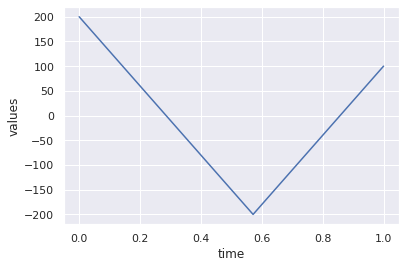

In [1]:
import numpy as np
import scipy.fft as fft
import pandas as pd
import seaborn as sns
sns.set() # set default styles

data = np.array([200, 100, 0, -100, -200, -100, 0, 100])
# Let's assume we get these values in 1 second
dt = 1/len(data)
# Let's get the transformed data and associated frequencies for the size and time
freqs = fft.fftfreq(data.size, dt)

# Plot the data
x = np.linspace(0, 1, num=data.size)
df = pd.DataFrame({'values':data, 'time':x})
sns.lineplot(data=df, x='time', y='values')

We can see our values start at 200, go down to 0 and -200 and then go up again, so they are cyclical like a sinusoid. An important detail is that I didn't include the 200 again in the end so that we have exactly one set of numbers that can be repeated forming a cycle without duplicated values (the 200 at the beginning of the next sequence will naturally follow the 100 at the end of the previous one).

Another important detail is that we are assumming the cycle repeats every 1 second, so we have a 1 Hz frequency in the data. The key word here is assumming: this is just a decision I made, I could have decided on any other time, and that would just change the meaning of the transformed values. In a real case we would have to know the actual time and sample frequency in order to properly interpret the DFT.

Let's plot our first DFT result.

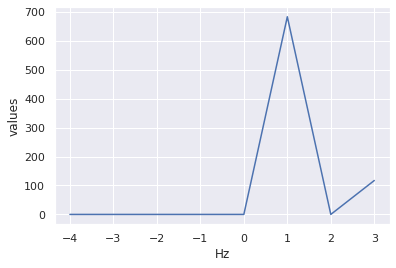

In [2]:
t = fft.rfft(data)

def plot_freqs(t, freqs):
    df = pd.DataFrame({'values':np.abs(t), 'Hz':freqs[0:t.size]})
    sns.lineplot(data=df, x='Hz', y='values')
    
plot_freqs(t, freqs)

Don't worry too much about how we came up with this plot if you just want to understand the DFT concept. The important thing here is that we got a clear peak at 1 Hz, and that is exactly what we would expect given our assumptions above. I'm assumming the smaller value at 3 is due to the original data not being an exact sinusoid but a very rough approximation so we cannot expect a perfectly clean result here.

Now let's make things more interesting. What if we add a higher frequency signal to the original data?

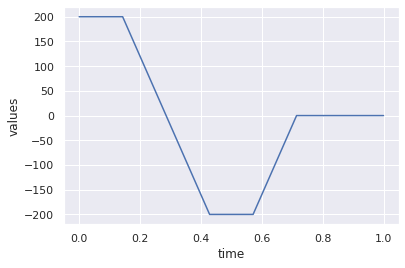

In [3]:
d2 = np.array([0, 100, 0, -100] * 2)
t = fft.rfft(data + d2)
# Plot the data
df = pd.DataFrame({'values':data+d2, 'time':x})
sns.lineplot(data=df, x='time', y='values')

Now the data looks a bit more complex. Note that the frequency of d2 is doubled (it cycles twice in the same time) and it's phase is different to the previous data (it starts with 0). Let's see what the frequencies plot looks like.

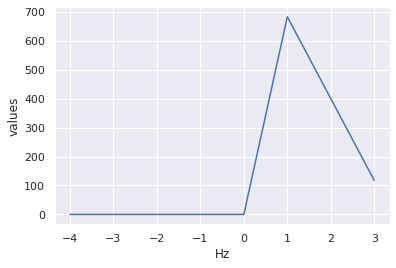

In [4]:
# Plot the frequencies
plot_freqs(t, freqs)

We got a higher value on 2 Hz than before, as expected. Note that even if the plot looks quite different, the actual values are the same, except for the one at 2 Hz. Also note that the value at 2 Hz is around half of the one at 1 Hz which makes sense, given that the data goes from 100 to -100 instead of 200 to -200.

## The complex part
Let's have a better look at the transformed numbers now. We will go back the original data and create a new data set with exactly the same numbers in the same order, but starting from 0 instead of 200. Another way to say this is that this data is in a different phase.

In [5]:
print('Original data\n', data)
p = np.concatenate((data[2:],data[0:2]))
print('\nDifferent phase data\n', p)
t = fft.rfft(data)
print('\nOriginal data, transformed\n', t)
pt = fft.rfft(p)
print('\nDifferent phase, transformed\n', pt)

Original data
 [ 200  100    0 -100 -200 -100    0  100]

Different phase data
 [   0 -100 -200 -100    0  100  200  100]

Original data, transformed
 [  0.        +0.00000000e+00j 682.84271247-2.84217094e-14j
   0.        -0.00000000e+00j 117.15728753-2.84217094e-14j
   0.        +0.00000000e+00j]

Different phase, transformed
 [ 0.00000000e+00  +0.j          2.84217094e-14+682.84271247j
  0.00000000e+00  -0.j         -2.84217094e-14-117.15728753j
  0.00000000e+00  +0.j        ]


We can see that the tranformed data looks quite different this time. This is reasonable. Remember that if we apply the inverse transformation to the transformed data we expect to get exactly the original data. So for different inputs, the outputs must necessarily be different.

However, the frequency of the input is the same, so the plot should be the same, right...?

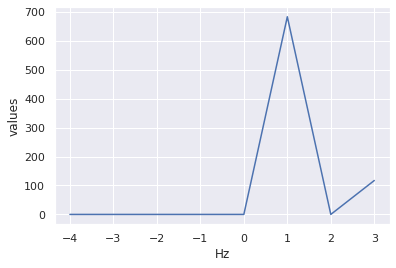

In [6]:
plot_freqs(pt, freqs)

It is indeed exactly the same. So what's going on here? If you pay attention to how we plot the data, you will see that we use the absolute numbers of the results (the DFT actually gives us complex numbers, as you can see above)

What will happen if we compare the absolutes of t and pt?

In [7]:
print((np.abs(t) == np.abs(pt)).all())


True


They are the same! This is also expected, because the frequency of the data is still the same so we still expect the same peak at 1 Hz. 

Where is the difference then? The beauty of the Discrete Fourier Transformation is that it encodes both the frequency magnitude and the phase in the same number by using complex numbers. If we understand a complex number as a vector and we have a look at the second element of the transformed results we will see it's a vector of the same size (same magnitude at that frequency, so same peak at that position in the plot) but rotated a different angle (different phase, or different place in the data at which the peak happens). We can see this better if we round the numbers:

In [8]:
fs = '({0.real:.0f} + {0.imag:.0f}i)'
print(fs.format(t[1]))
print(fs.format(pt[1]))

(683 + -0i)
(0 + 683i)


Now the results don't look that different! It's actually 683 in both cases, it's just that in one case the value is in the real part of the number and in the other case it's in the imaginary part. Or, if we understand the complex number as a vector, it's a vector of the same size pointing at a differen direction.

I'm getting ahead of myself here, but in case you're wondering this is why we need two images to store the fourier transformation of an original image: one stores the frequency data, and the other one the phase data.

## Changing magnitudes
What would happen if we plot the frequencies for a similar dataset but with the values doubled?

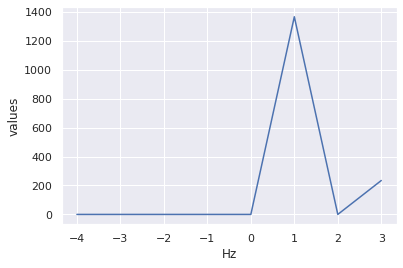

In [9]:
plot_freqs(fft.rfft(data*2), freqs)

In this case the magnitude in the frequency plot is also doubled. We can understand the magnitude as a kind of relative weight of a given frequency, how important is that frequency in the data compared to the others. The bigger the numbers that are contributing to that frequency (or, the bigger the amplitude in the original data) the bigger the magnitude in the transformed data.

We already got to experiment with this concept above, where the 2 Hz value was smaller than the 1 Hz because the numbers changing at that frequency were smaller.

## Making data less obviously sinusoidal
All the examples until now featured data repeated in a sinusoidal way: values go up, then down, then up again, in a cyclical and predictable way. This leads to very clear peaks in the transformed data because the data is obviously cyclical at some specific frequencies. 

What would happen if we had data that is not cyclical. For example, a simple data set where have have mostly 0s like this:

In [10]:
nc = np.array([0, 100, 0, -100, 0, 0, 0, 0, 0])

Notice that the data still goes up and down, and back to 0, however, then stays at 0. It doesn't cycle anymore. We could argue that this is a simpler input than we had before. However if we check the transformed data and plot the frequencies...

[   0.          +0.j          126.60444431 +22.32377941j
   67.36481777-185.08331568j -150.         -86.60254038j
  -43.96926208 +52.40052605j]


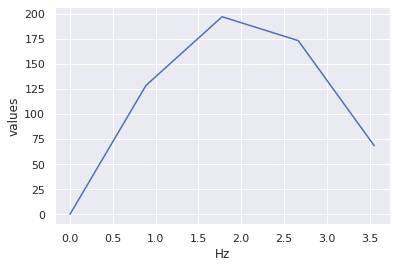

In [11]:
t = fft.rfft(nc)
print(t)
ncfreqs = fft.fftfreq(nc.size, dt)
plot_freqs(t, ncfreqs)

... we get a pretty different result. Now we don't have an obvious peak at any particular frequency. To understand this, think about the basic meaning of a Fourier Transform. Fourier's main insight was that any signal (essentially any series of numbers) can be expressed as the sum of sinusoids. So if you input a sinusoid, you get a very simple tranformation that basically tells you: yeah, that was a sinusoid of this frequency. If you input anything else, the result will be much more complicated. It has to be! Could you tell just by looking at our input in this example which sinusioids would give you exactly that result if they were added up? You will see it's quite a challenge if you try.

So this result is telling us that in order to get that simple input, we will need to add several sinusoids of different amplitudes, frequencies and phases.

## Moving all the numbers up 
Let's try a different thing now, let's go back to the original cyclical data but displace it all up so that it's no longer oscillating around 0.

In [12]:
dd = data+200
dd

array([400, 300, 200, 100,   0, 100, 200, 300])

The data still has the same frequency so we can expect a similar peak at 1 Hz in the DFT. How else will the frequency plot change?

[1600.        +0.00000000e+00j  682.84271247-2.84217094e-14j
    0.        -0.00000000e+00j  117.15728753-2.84217094e-14j
    0.        +0.00000000e+00j]


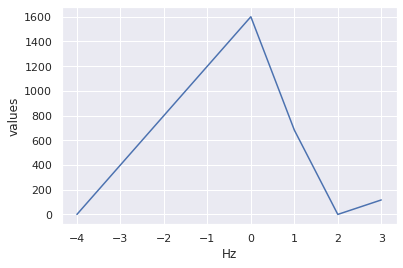

In [13]:
ddt = fft.rfft(dd)
print(ddt)
plot_freqs(ddt, freqs)

This plot looks very different but if we pay attention to it we can see that actually the only different is at 0 Hz. The 0 Hz value (also called the DC term) is a special one: it represents the average of all the other values. If you pay attention all the previous examples you can see it was always 0. The data always oscillated regularly around 0 so it makes sense intuitively.

However, the value at DC is too big to be the average of the values, so what happened here? The reason is that our results are not normalized. It's a common practice to normalize the values using the size of the original data, like this:

[200.        +0.00000000e+00j  85.35533906-3.55271368e-15j
   0.        -0.00000000e+00j  14.64466094-3.55271368e-15j
   0.        +0.00000000e+00j]


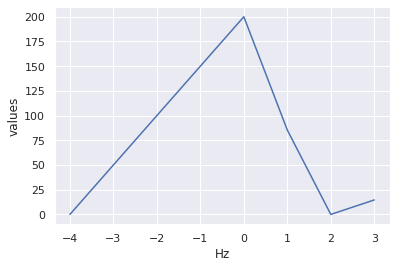

In [16]:
nddt = ddt/dd.size
print(nddt)
plot_freqs(nddt, freqs)


Now it makes much more sense! The value at 0 is 200, which is exactly what we would expect, since we add 200 to every value in the original data, making the new average 200 instead of 0.

In [17]:
np.average(dd), nddt[0]

(200.0, (200+0j))

We can see that are indeed the same value, even without the need to take the absolute of the complex number. It will always be a real number.

## Thanks for reading!
I hope these examples were useful to actually make sense of the results of a DFT. Hopefully, having understood its behaviour with very small inputs, making sense of more realistic ones will become easier.
